In [1]:
import sys
# Add the src directory to the Python path
sys.path.append('../src')

import pandas as pd
# Set the maximum number of rows to 100 (default is 10 in newer versions)
pd.set_option('display.max_rows', 500)
# Set the maximum number of columns to 50 (default is 20)
pd.set_option('display.max_columns', 1500)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

# Define the directory containing the CSV files
directory = '/home/sayem/Desktop/SODIndoorLoc/data/raw_data/Train'
base_dir = Path("/home/sayem/Desktop/SODIndoorLoc/SODIndoorLoc_data")

# Initialize an empty DataFrame and a list for RSS values
combined_df = pd.DataFrame()
rss_list = []

# Read and combine all CSV files into a single DataFrame
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
for file_path in csv_files:
    df = pd.read_csv(file_path)
    mac_columns = [col for col in df.columns if col.startswith('MAC')]
    # Calculate average RSS and store in the list
    rss_list.append(df[mac_columns].mean(axis=1))
    # Append the DataFrame without the MAC columns
    combined_df = pd.concat([combined_df, df.drop(columns=mac_columns)], ignore_index=True)

# Concatenate the RSS values as a new column to the combined DataFrame
combined_df['RSS'] = pd.concat(rss_list, ignore_index=True)


# # Calculate average RSS from MAC columns
# mac_columns = [col for col in combined_df.columns if col.startswith('MAC')]
# combined_df['RSS'] = combined_df[mac_columns].mean(axis=1)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(combined_df, test_size=0.2)

grid_size = 1.0
image_size = (10, 10) 
# Define the columns for grouping
group_cols = ['BuildingID', 'FloorID', 'SceneID', 'UserID', 'PhoneID', 'SampleTimes']

In [3]:
train_df

,ECoord,NCoord,FloorID,BuildingID,SceneID,UserID,PhoneID,SampleTimes,RSS
870,50.000,19.400,3,1,2,4,3,1,22.634615
605,55.800,36.500,2,1,3,4,3,1,-1.153846
1406,937.927,879.455,4,2,1,6,7,1,83.887608
1535,969.839,907.999,4,2,1,10,8,1,71.697406
262,52.500,51.800,1,1,1,4,3,1,17.711538
...,...,...,...,...,...,...,...,...,...
106,53.300,22.700,1,1,1,4,3,1,-0.653846
705,61.200,19.300,3,1,2,4,3,1,43.980769
1092,78.430,9.850,4,3,1,2,2,1,-101.303030
1363,911.724,878.259,4,2,1,7,6,1,66.092219


In [4]:
train_df.columns

Index(['ECoord', 'NCoord', 'FloorID', 'BuildingID', 'SceneID', 'UserID',
       'PhoneID', 'SampleTimes', 'RSS'],
      dtype='object')

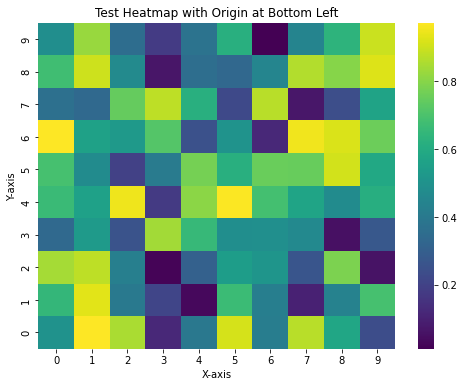

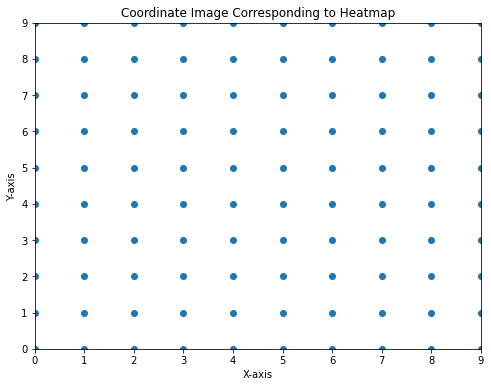

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a simple dataset for the heatmap
data = np.random.rand(10, 10)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(data, cmap='viridis', cbar=True)

# Set the tick labels to start from 0 at the bottom
ax.set_xticklabels(np.arange(0, 10))
ax.set_yticklabels(np.arange(0, 10)[::-1])

plt.title('Test Heatmap with Origin at Bottom Left')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


# Dimensions of the heatmap
height, width = 10, 10

# Generate grid coordinates
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

# Flatten the coordinate matrices to get a list of x and y coordinates
x_coords = x_coords.flatten()
y_coords = y_coords.flatten()

# No need to invert y-coordinates, as they should start from the bottom
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords)

# Set the limits to match the heatmap
plt.xlim(0, width - 1)
plt.ylim(0, height - 1)

plt.title('Coordinate Image Corresponding to Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_axes_limits(floor_data, grid_size):
    min_x, max_x = floor_data['ECoord'].min(), floor_data['ECoord'].max()
    min_y, max_y = floor_data['NCoord'].min(), floor_data['NCoord'].max()
    
    grid_min_x = np.floor(min_x / grid_size)
    grid_max_x = np.ceil(max_x / grid_size)
    grid_min_y = np.floor(min_y / grid_size)
    grid_max_y = np.ceil(max_y / grid_size)

    return grid_min_x, grid_max_x, grid_min_y, grid_max_y

def generate_heatmap(floor_data, grid_size, save_path, grid_min_x, grid_max_x, grid_min_y, grid_max_y):
    floor_data['grid_x'] = np.floor(floor_data['ECoord'] / grid_size)
    floor_data['grid_y'] = np.floor(floor_data['NCoord'] / grid_size)

    heatmap_data = floor_data.groupby(['grid_x', 'grid_y'])['RSS'].mean().unstack()
    heatmap_data = heatmap_data.iloc[::-1]  # Flip vertically

    # Fill NaNs with the minimum value or another suitable value
    heatmap_data.fillna(heatmap_data.min().min(), inplace=True)

    plt.figure(figsize=image_size)
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar=True)  # Using a diverging colormap
    plt.xlim(grid_min_x, grid_max_x)
    plt.ylim(grid_min_y, grid_max_y)
    plt.gca().invert_yaxis()

    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def generate_coordinate_image(floor_data, grid_size, save_path, grid_min_x, grid_max_x, grid_min_y, grid_max_y):
    plt.figure(figsize=image_size)

    # Use original coordinates for plotting
    plt.scatter(floor_data['ECoord'], floor_data['NCoord'], alpha=0.7)
    plt.xlabel('ECoord')
    plt.ylabel('NCoord')
    plt.title('Coordinate Image')

    # Calculate the minimum and maximum limits for both axes
    x_min, x_max = grid_min_x * grid_size, grid_max_x * grid_size
    y_min, y_max = grid_min_y * grid_size, grid_max_y * grid_size

    # Find the minimum of the minima for both axes
    common_min = min(x_min, y_min)

    # Set the same start point for both axes
    plt.xlim(common_min, x_max)
    plt.ylim(common_min, y_max)

    # Ensure y-axis starts from bottom
    plt.gca().invert_yaxis()

    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [7]:

# # Create a sample DataFrame with random data for the sanity check
# np.random.seed(0)
# num_samples = 100
# floor_data = pd.DataFrame({
#     'ECoord': np.random.uniform(0, 100, num_samples),
#     'NCoord': np.random.uniform(0, 100, num_samples),
#     'RSS': np.random.uniform(-30, 60, num_samples)  # Random RSS values
# })

# # Define grid size and image size
# grid_size = 10
# image_size = (8, 6)  # Width, Height in inches

# # Compute axes limits
# grid_min_x, grid_max_x, grid_min_y, grid_max_y = get_axes_limits(floor_data, grid_size)

# # Generate heatmap
# heatmap_path = "heatmap_test.png"
# generate_heatmap(floor_data, grid_size, heatmap_path, grid_min_x, grid_max_x, grid_min_y, grid_max_y)

# # Generate coordinate image
# coordinate_image_path = "coordinate_image_test.png"
# generate_coordinate_image(floor_data, grid_size, coordinate_image_path, grid_min_x, grid_max_x, grid_min_y, grid_max_y)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

def process_and_save_images(df, base_dir, group_cols, grid_size):
    unique_combinations = df.groupby(group_cols).size().reset_index(name='Unique Combination Count')
    pair_counts = {}

    for index, row in unique_combinations.iterrows():
        building, floor = row['BuildingID'], row['FloorID']
        pair_counts.setdefault((building, floor), 0)
        pair_counts[(building, floor)] += 1
        pair_index = pair_counts[(building, floor)]

        group_data = df[(df['BuildingID'] == building) & (df['FloorID'] == floor)].copy()

        if group_data.empty:
            continue

        # Here you pass grid_size to the get_axes_limits function
        min_x, max_x, min_y, max_y = get_axes_limits(group_data, grid_size)

        pair_dir = base_dir / f"Building_{building}" / f"Floor_{floor}" / f"Pair_{pair_index}"
        pair_dir.mkdir(parents=True, exist_ok=True)

        heatmap_path = pair_dir / "heatmap.png"
        coordinate_image_path = pair_dir / "coord_map.png"

        generate_heatmap(group_data, grid_size, heatmap_path, min_x, max_x, min_y, max_y)
        generate_coordinate_image(group_data, grid_size, coordinate_image_path, min_x, max_x, min_y, max_y)
        break


# Process and save images for training and validation sets
process_and_save_images(train_df, base_dir / 'train', group_cols, grid_size)
process_and_save_images(valid_df, base_dir / 'validation', group_cols, grid_size)